In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,explained_variance_score,confusion_matrix,accuracy_score,classification_report,log_loss
import seaborn as sns

In [2]:
data_cleveland = pd.read_excel('Cleveland.xlsx')
data_cleveland.shape
data_cleveland.head()
data_cleveland.isnull().sum()



Location          0
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [3]:
#data_cleveland[data_cleveland['Cholesterol']==0].
data_cleveland['Cholesterol'].value_counts()

0      48
193     4
223     3
225     3
289     3
       ..
236     1
235     1
407     1
255     1
318     1
Name: Cholesterol, Length: 124, dtype: int64

In [4]:
# Handeling the cholestrol column 
data_cleveland['Cholesterol'].replace(0,data_cleveland['Cholesterol'].mean(),inplace=True)

In [5]:
data_cleveland['Cholesterol'].any()==0

False

In [6]:
data_cleveland.astype

<bound method NDFrame.astype of        Location  Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS  \
0    Cleaveland   54   M           ASY        200   198.000000          0   
1    Cleaveland   56   F           ASY        200   288.000000          1   
2    Cleaveland   64   F           ASY        200   199.715596          0   
3    Cleaveland   54   M           ATA        192   283.000000          0   
4    Cleaveland   63   M           ASY        185   199.715596          0   
..          ...  ...  ..           ...        ...          ...        ...   
213  Cleaveland   46   M           ASY        115   199.715596          0   
214  Cleaveland   62   M           ASY        115   199.715596          1   
215  Cleaveland   46   M           ASY        110   202.000000          0   
216  Cleaveland   48   F           ASY        108   163.000000          0   
217  Cleaveland   60   F           NAP        102   318.000000          0   

    RestingECG  MaxHR ExerciseAngina  Oldpe

In [7]:
data_cleveland.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.00000,218.000000
mean,57.775229,145.692661,243.689673,0.302752,129.811927,1.32156,0.811927
std,8.540493,17.011572,59.425367,0.460506,24.178035,1.16419,0.391670
min,32.000000,102.000000,100.000000,0.000000,67.000000,0.00000,0.000000
25%,52.000000,140.000000,199.715596,0.000000,113.000000,0.00000,1.000000
50%,58.000000,144.000000,225.500000,0.000000,125.000000,1.20000,1.000000
75%,64.000000,157.250000,283.750000,1.000000,149.000000,2.00000,1.000000
max,77.000000,200.000000,529.000000,1.000000,195.000000,6.20000,1.000000


In [8]:
#Investigating all features within a column

for columns in data_cleveland:
    unique_values = np.unique(data_cleveland[columns])
    count_values = len(unique_values)
    if count_values < 10:
        print('The number of values for feature {} is:{} -- {}'.format(columns,count_values,unique_values))
    else:
        print('The number of values for feature {} is:{}'.format(columns,count_values))

The number of values for feature Location is:1 -- ['Cleaveland']
The number of values for feature Age is:40
The number of values for feature Sex is:2 -- ['F' 'M']
The number of values for feature ChestPainType is:4 -- ['ASY' 'ATA' 'NAP' 'TA']
The number of values for feature RestingBP is:39
The number of values for feature Cholesterol is:124
The number of values for feature FastingBS is:2 -- [0 1]
The number of values for feature RestingECG is:3 -- ['LVH' 'Normal' 'ST']
The number of values for feature MaxHR is:78
The number of values for feature ExerciseAngina is:2 -- ['N' 'Y']
The number of values for feature Oldpeak is:30
The number of values for feature ST_Slope is:3 -- ['Down' 'Flat' 'Up']
The number of values for feature HeartDisease is:2 -- [0 1]


In [9]:
#Calculating the Corelation values
data_cleveland.columns
corr = data_cleveland.corr()

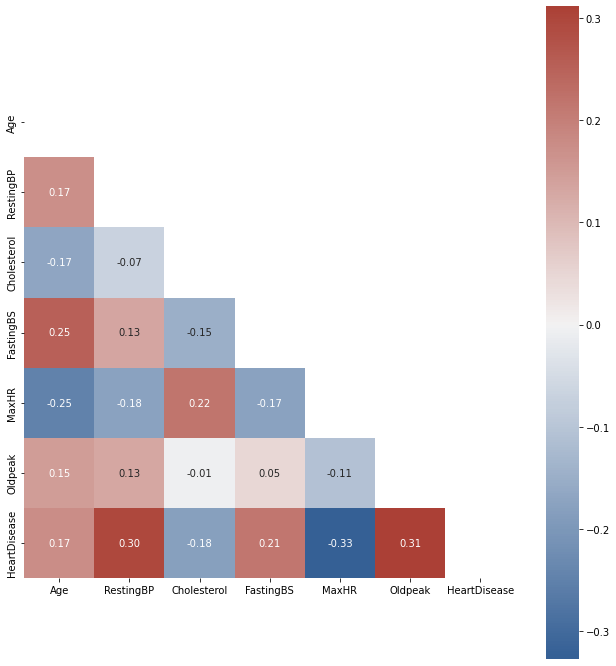

In [10]:
c = data_cleveland.drop(['Location'],axis=1)
# Calculate pairwise-correlation
matrix = c.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(11, 12))
sns.heatmap(matrix, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.show();

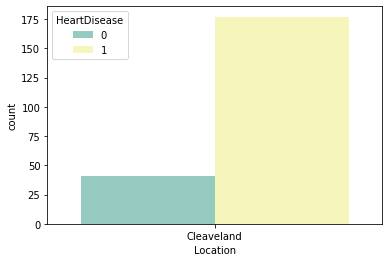

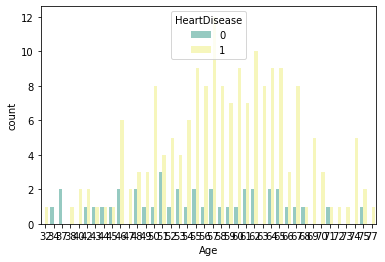

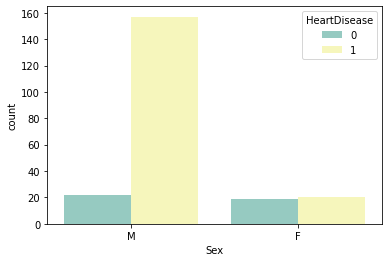

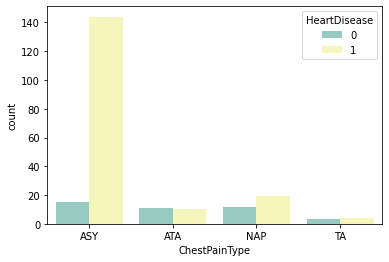

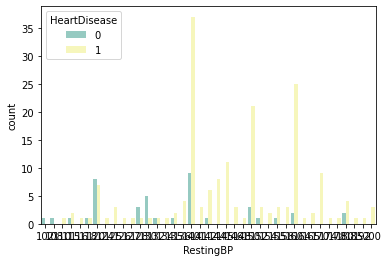

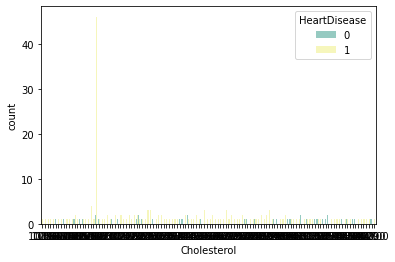

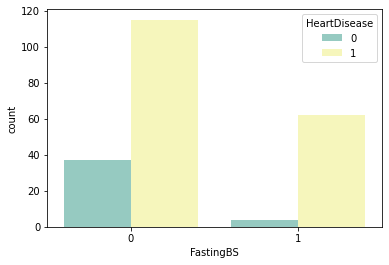

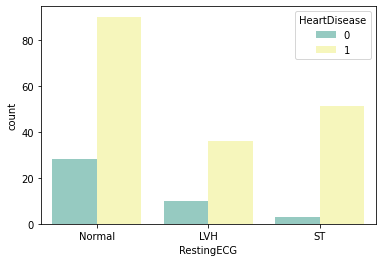

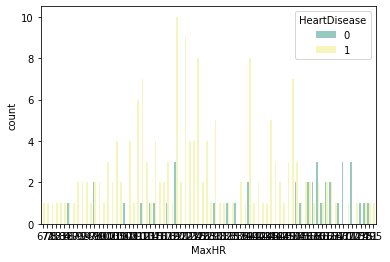

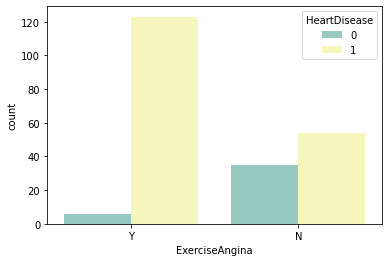

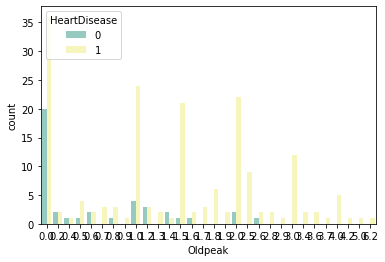

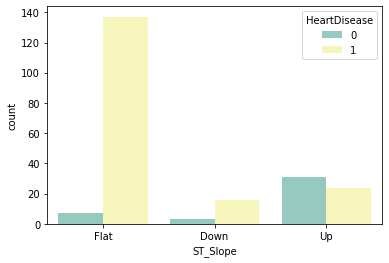

In [11]:
#Evaluating each feature and observing the affect on Y
feature = ['Location', 'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
       'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak',
       'ST_Slope']

for f in feature:
    sns.countplot(x = f,data = data_cleveland,palette='Set3',hue = 'HeartDisease')
    plt.show()

In [12]:
#Feature Selection
# Converting all variables 
Cleve_data = pd.get_dummies(data_cleveland,columns = ["ChestPainType", "Sex","RestingECG","ExerciseAngina","ST_Slope"],prefix=["ChestPainType", "Sex","RestingECG","ExerciseAngina","ST_Slope"])
Cleve_data.shape


(218, 22)

#As the ration of heartdisease is very different, we need to balance the dataset to avoid any bias in our model. We have used an oversampling technique to deal with the issue without loosing any data

In [13]:
X = Cleve_data.drop(['HeartDisease','Location'],axis=1)    # Predictor feature columns 
Y = Cleve_data['HeartDisease'].values   # Predicted class (1=True, 0=False)

#Normalizing the quantitative columns in the data 
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']] = mms.fit_transform(X[['Age',
                                                                              'RestingBP',
                                                                              'Cholesterol',
                                                                              'MaxHR',
                                                                             'Oldpeak']])

X

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,Sex_F,Sex_M,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.488889,1.000000,0.228438,0,0.585938,0.322581,1,0,0,0,0,1,0,1,0,0,1,0,1,0
1,0.533333,1.000000,0.438228,1,0.515625,0.645161,1,0,0,0,1,0,1,0,0,0,1,1,0,0
2,0.711111,1.000000,0.232437,0,0.570312,0.161290,1,0,0,0,1,0,0,1,0,0,1,0,1,0
3,0.488889,0.918367,0.426573,0,1.000000,0.000000,0,1,0,0,0,1,1,0,0,1,0,0,0,1
4,0.688889,0.846939,0.232437,0,0.242188,0.000000,1,0,0,0,0,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.311111,0.132653,0.232437,0,0.359375,0.241935,1,0,0,0,0,1,0,1,0,0,1,0,1,0
214,0.666667,0.132653,0.232437,1,0.476562,0.403226,1,0,0,0,0,1,0,1,0,0,1,1,0,0
215,0.311111,0.081633,0.237762,0,0.648438,0.000000,1,0,0,0,0,1,0,1,0,0,1,0,1,0
216,0.355556,0.061224,0.146853,0,0.843750,0.322581,1,0,0,0,1,0,0,1,0,1,0,0,0,1


/Users/saim/miniforge3/envs/tfm1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

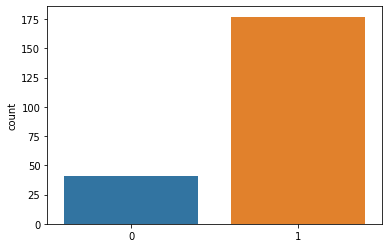

In [14]:
no_hd=data_cleveland[data_cleveland['HeartDisease']==0]
yes_hd=data_cleveland[data_cleveland['HeartDisease']== 1]
data_cleveland['HeartDisease'].value_counts()

sns.countplot(Y)

In [15]:
#Handeling imbalances in dataset
from imblearn.combine import SMOTETomek
#Implementing oversampling for handeling imbalance
smk = SMOTETomek(random_state = 42)
X_res,y_res = smk.fit_resample(X,Y)

Original Dataset Shape Counter({1: 177, 0: 41})
Resampled Dataset Shape Counter({1: 175, 0: 175})


/Users/saim/miniforge3/envs/tfm1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

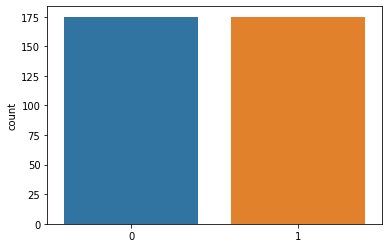

In [16]:
from collections import Counter
print('Original Dataset Shape {}'.format(Counter(Y)))
print('Resampled Dataset Shape {}'.format(Counter(y_res)))
sns.countplot(y_res)

Since Cholestrol Level Cannot be 0 we are replacing 0 with mean of the column 'Cholestrol'

# LOGISTIC REGRESSION

In [17]:
columns = X_res.columns
columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'Sex_F', 'Sex_M', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N',
       'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

In [18]:
#Splitting Data for Training and Testing
X_train, X_test, y_train, y_test  = train_test_split(X_res,y_res, 
                                                     train_size=0.7,
                                                     test_size = 0.3, 
                                                     random_state = 55,
                                                     stratify = y_res )



In [19]:
#Shapes of each split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(244, 20)
(105, 20)
(244,)
(105,)


In [20]:
#Running Log model
model = LogisticRegression(solver='liblinear', max_iter=1000)
log_results=model.fit(X_train, y_train)

#Train Accuracy
print('Training accuracy is {}'.format(model.score(X_train,y_train)))
#predict on training set
y_pred_train = model.predict(X_train)
#Predictions using test set
y_pred = model.predict(X_test)

Training accuracy is 0.9590163934426229


Model Evaluation

In [21]:
#Accuracy Score Training Set
print('Training Set accuracy is {}'.format(model.score(X_train,y_train)))
# Accuracy of test set
print('Test Set accuracy is {}'.format(model.score(X_test,y_test)))

#Classification Report
print(classification_report(y_test,y_pred))

y_pred

#Model Gives us very good precision and recall as well, Our focus here is Recall

Training Set accuracy is 0.9590163934426229
Test Set accuracy is 0.9333333333333333
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        53
           1       0.94      0.92      0.93        52

    accuracy                           0.93       105
   macro avg       0.93      0.93      0.93       105
weighted avg       0.93      0.93      0.93       105



array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

In [22]:
model.coef_

array([[ 0.52752086,  0.77802667, -0.59246948,  0.98099281, -0.88146428,
         0.81906091,  1.46277659,  0.01497974, -0.15872057, -0.05906411,
        -0.80802358,  0.54852617,  0.68863494, -0.53204601,  1.33944281,
        -0.60117076,  1.44798099,  0.30495089,  1.73024704, -1.4487808 ]])

In [23]:
#Confusion Matrix
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

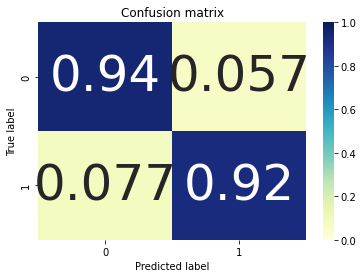

In [24]:
lr_cm = confusion_matrix(y_test,y_pred)
lrcm_norm = lr_cm/lr_cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(lrcm_norm,model.classes_)

In [25]:
# def get_feature_importance(model,feature_names):
#     feature_importance = (
#     pd.DataFrame({
#             'variable':columns,
#             'coefficient':model.coef_[0]
#                 }
#                 )
#     .round(decimals=4)\
#     .sort_values('coefficient',ascending = False).reset_index(drop = True)\
#     .style.bar(color=['red','green'],align='zero')\
#     )
#     return feature_importance
# get_feature_importance(model,feature)

In [26]:
my_dict = dict(zip(columns,model.coef_[0]))

In [27]:
all_features = pd.DataFrame({'variable':columns,'coefficient':model.coef_[0]}).round(decimals=4)\
.sort_values('coefficient',ascending = False).reset_index(drop=True)
#.set_index('variable')\

#

In [28]:
confusion_matrix(y_test,y_pred)


array([[50,  3],
       [ 4, 48]])

In [29]:
all_features.style.bar(color=['red','green'],align='zero')

,variable,coefficient
0,ST_Slope_Flat,1.730200
1,ChestPainType_ASY,1.462800
2,ExerciseAngina_Y,1.448000
3,RestingECG_ST,1.339400
4,FastingBS,0.981000
5,Oldpeak,0.819100
6,RestingBP,0.778000
7,RestingECG_LVH,0.688600
8,Sex_M,0.548500
9,Age,0.527500


In [30]:
import statsmodels.api as sm
stats_mod = sm.OLS(y_res,X_res).fit()
stats_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.885
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                              126.4
Date:                Sun, 10 Apr 2022   Prob (F-statistic):                   2.10e-141
Time:                        16:46:34   Log-Likelihood:                          2.5057
No. Observations:                 350   AIC:                                      34.99
Df Residuals:                     330   BIC:                                      112.1
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Age                   0.0792      0.079      1.000      0.318      -0.077       0.235
RestingBP             0.1797      0.088      2.034      0.043       0.006       0.353
Cholesterol          -0.0743      0.109     -0.681      0.496      -0.289       0.140
FastingBS             0.1418      0.040      3.577      0.000       0.064       0.220
MaxHR                -0.0917      0.083     -1.110      0.268      -0.254       0.071
Oldpeak               0.2056      0.102      2.015      0.045       0.005       0.406
ChestPainType_ASY     0.1297      0.054      2.411      0.016       0.024       0.235
ChestPainType_ATA     0.0085      0.062      0.138      0.890      -0.113       0.130
ChestPainType_NAP     0.0703      0.053      1.334      0.183      -0.033       0.174
ChestPainType_TA      0.0376      0.097      0.389      0.698      -0.152       0.228
Sex_F                -0.1461      0.081     -1.803      0.072      -0.306       0.013
Sex_M                -0.0120      0.080     -0.150      0.880      -0.169       0.145
RestingECG_LVH        0.1544      0.058      2.657      0.008       0.040       0.269
RestingECG_Normal     0.0240      0.051      0.469      0.639      -0.077       0.125
RestingECG_ST         0.1443      0.065      2.217      0.027       0.016       0.272
ExerciseAngina_N      0.0399      0.070      0.572      0.567      -0.097       0.177
ExerciseAngina_Y      0.2952      0.078      3.786      0.000       0.142       0.449
ST_Slope_Down         0.2984      0.095      3.147      0.002       0.112       0.485
ST_Slope_Flat         0.3972      0.070      5.697      0.000       0.260       0.534
ST_Slope_Up          -0.0131      0.069     -0.190      0.849      -0.148       0.122
==============================================================================
Omnibus:                       38.580   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.388
Skew:                           0.529   Prob(JB):                     7.12e-22
Kurtosis:                       5.358   Cond. No.                         18.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# selected_features = all_features.drop([12,13,14,15])

In [32]:
# selected_features = selected_features.reset_index(drop=True)

In [36]:
# filtered= []
# for i in selected_features['variable']:
#     filtered.append(i)

In [34]:
# #LOG REG WITH SELECTED FEATURES
# X_lg_1 = Cleve_data[filtered]
# X_new_1,y_new_1 = smk.fit_resample(X_lg_1,Y_logreg)
# X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(X_new_1,y_new_1, train_size=0.7,test_size = 0.3, random_state = 55,stratify = y_new_1)
# #Validation split
# X_train_1,X_valid_1,y_train_1,y_valid_1 = train_test_split(X_train_1,y_train_1,train_size = 0.80 , test_size = 0.2,random_state=55,stratify=y_train_1)
# model.fit(X_train_1, y_train_1)
# y_pred_1 = model.predict(X_test_1)


In [37]:
# #Accuracy Score Training Set
# print('Training Set accuracy is {}'.format(model.score(X_train_1,y_train_1)))
# # Accuracy of test set
# print('Test Set accuracy is {}'.format(model.score(X_test_1,y_test_1)))

# #Classification Report
# print(classification_report(y_test_1,y_pred_1))

# y_pred
# predict_proba_1 = model.predict_proba(X_test_1)

In [38]:
# new_scores = pd.DataFrame({'variable':filtered,'coefs':model.coef_[0]}).round(decimals=4)\
# .sort_values('coefs',ascending = False).reset_index(drop=True)\
# .style.bar(color=['red','green'],align='zero')

# new_scores 

EVALUATION METRIC 2 - CONFUSION MATRIX

In [39]:
# #Visualizing CM
# cm = confusion_matrix(y_test_1,y_pred_1)
# print(cm)
# # interms of percentage
# cm_norm = cm/cm.sum(axis=1).reshape(-1,1)
# cm_norm

In [ ]:
# plot_confusion_matrix(cm_norm,model.classes_)

# CLASSIFICATION TREES

In [40]:
params = {
    'criterion':['gini','entropy'],
    'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,None],
    'min_samples_split':[0.1,0.2,0.3],
    'min_samples_leaf':[1,2,3,4,5],
    'max_features':['auto','sqrt','log2',None],
    'splitter':['best','random']
    
}

In [41]:
#Choosing best params using GridSearchCV
clf = GridSearchCV(DecisionTreeClassifier(random_state=0),param_grid=params,cv=8,n_jobs=-1)

In [42]:
clf.fit(X_train,y_train)

GridSearchCV(cv=8, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [0.1, 0.2, 0.3],
                         'splitter': ['best', 'random']})

In [43]:
x = clf.best_estimator_
print(x)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=0.1,
                       random_state=0, splitter='random')


In [44]:
dt = x
dt.fit(X_train,y_train)
dt_y_pred= dt.predict(X_test)


In [45]:
print('The Train Data Accuracy is {}'.format(dt.score(X_train,y_train)))
print('The Test Data Accuracy is {}'.format(dt.score(X_test,y_test)))
print(classification_report(y_test,dt_y_pred))

The Train Data Accuracy is 0.9262295081967213
The Test Data Accuracy is 0.8857142857142857
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        53
           1       0.87      0.90      0.89        52

    accuracy                           0.89       105
   macro avg       0.89      0.89      0.89       105
weighted avg       0.89      0.89      0.89       105



In [46]:
fi_col =[]
fi = []
from sklearn import metrics

#Running Feature Importance 
for i,column in enumerate(Cleve_data.drop(['HeartDisease','Location'],axis=1)):
    print('The Feature importance for {} is:{}'.format(column,dt.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])
    

The Feature importance for Age is:0.0
The Feature importance for RestingBP is:0.0
The Feature importance for Cholesterol is:0.0
The Feature importance for FastingBS is:0.0
The Feature importance for MaxHR is:0.03466029168107982
The Feature importance for Oldpeak is:0.0
The Feature importance for ChestPainType_ASY is:0.0
The Feature importance for ChestPainType_ATA is:0.0
The Feature importance for ChestPainType_NAP is:0.0
The Feature importance for ChestPainType_TA is:0.0
The Feature importance for Sex_F is:0.0
The Feature importance for Sex_M is:0.09151938565210142
The Feature importance for RestingECG_LVH is:0.0
The Feature importance for RestingECG_Normal is:0.0
The Feature importance for RestingECG_ST is:0.0
The Feature importance for ExerciseAngina_N is:0.0
The Feature importance for ExerciseAngina_Y is:0.1939768366458837
The Feature importance for ST_Slope_Down is:0.06700893832280769
The Feature importance for ST_Slope_Flat is:0.6128345476981275
The Feature importance for ST_Slop

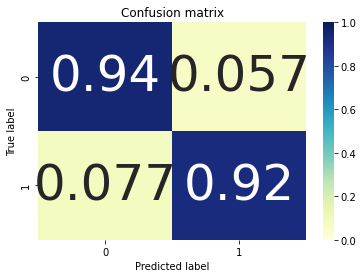

In [47]:
df_cm =confusion_matrix(y_test,y_pred)
df_cm
dfcm_percentage = df_cm/df_cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(dfcm_percentage,dt.classes_)

In [48]:
fi_df=zip(fi_col,fi)
fi_df = pd.DataFrame(fi_df,columns=['Feature','Feature Importance'])
importance = fi_df.sort_values('Feature Importance',ascending = False).reset_index(drop = True)
importance


,Feature,Feature Importance
0,ST_Slope_Flat,0.612835
1,ExerciseAngina_Y,0.193977
2,Sex_M,0.091519
3,ST_Slope_Down,0.067009
4,MaxHR,0.034660
5,Age,0.000000
6,ExerciseAngina_N,0.000000
7,RestingECG_ST,0.000000
8,RestingECG_Normal,0.000000
9,RestingECG_LVH,0.000000


In [ ]:
# columns_to_keep = importance['Feature'][0:6]
# Cleve_data[columns_to_keep].shape